In [1]:
%matplotlib inline
import pickle
import tensorflow as tf
import gym
import saliency
import numpy as np
from matplotlib import pylab as P
from tqdm import *
from IPython import display

from baselines.common.vec_env.vec_frame_stack import VecFrameStack
from baselines.common.cmd_util import make_atari_env
from baselines.a2c.utils import conv_to_fc
from ppo2 import Runner

In [2]:
ENV_NAME = "DemonAttackNoFrameskip-v0"
TRAIN_FOLDER = './demon_attack_seed_0/'

env = VecFrameStack(make_atari_env(ENV_NAME, 8, 0), 4)
nact = env.action_space.n

In [3]:
with open(TRAIN_FOLDER + "make_model.pkl", "rb") as f:
    make_model = pickle.load(f)

In [4]:
tf.Session().__enter__()

model = make_model()
model.load(TRAIN_FOLDER + 'checkpoints/00001')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
def conv_copy(x, scope, wold, bold, *, nf, rf, stride, pad='VALID', init_scale=1.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[3].value
        w = tf.identity(wold)
        b = tf.identity(bold)
        return tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding=pad)+b

def fc_copy(x, scope, nh, wold, bold, *, init_scale=1.0, init_bias=0.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[1].value
        w = tf.identity(wold)
        b = tf.identity(bold)
        return tf.matmul(x, w)+b   
    
def ShowGrayscaleImage(im, title='', ax=None, pc=''):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title + str(pc))
    # P.savefig(title + ".png")
    
def ShowImage(im, title='', ax=None, pc=''):
    if ax is None:
        P.figure()
    P.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im)
    P.title(title + str(pc))

In [6]:
graph = tf.get_default_graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 84, 84, 4))
    with tf.variable_scope("saliency", reuse=False):
        scaled_images = tf.cast(images, tf.float32) / 255.
        activ = tf.nn.relu
        wold1 = graph.get_tensor_by_name('model/c1/w:0')
        bold1 = graph.get_tensor_by_name('model/c1/b:0')
        h = activ(conv_copy(scaled_images, 'c1', wold1, bold1, nf=32, rf=8, stride=4))
        wold2 = graph.get_tensor_by_name('model/c2/w:0')
        bold2 = graph.get_tensor_by_name('model/c2/b:0')
        h2 = activ(conv_copy(h, 'c2', wold2, bold2, nf=64, rf=4, stride=2))
        wold3 = graph.get_tensor_by_name('model/c3/w:0')
        bold3 = graph.get_tensor_by_name('model/c3/b:0')
        h3 = activ(conv_copy(h2, 'c3', wold3, bold3, nf=64, rf=3, stride=1))
        h3 = conv_to_fc(h3)
        wold4 = graph.get_tensor_by_name('model/fc1/w:0')
        bold4 = graph.get_tensor_by_name('model/fc1/b:0')
        h4 = activ(fc_copy(h3, 'fc1', 512, wold4, bold4))
        wold5 = graph.get_tensor_by_name('model/pi/w:0')
        bold5 = graph.get_tensor_by_name('model/pi/b:0')
        logits = fc_copy(h4, 'pi', nact, wold5, bold5)
        
        neuron_selector = tf.placeholder(tf.int32)
        y_selected = logits[0][neuron_selector]
        prediction = tf.argmax(logits, 1)

In [7]:
nsteps = 1
gamma = 0.99
lam = 0.95
runner = Runner(env=env, model=model, nsteps=nsteps, gamma=gamma, lam=lam)


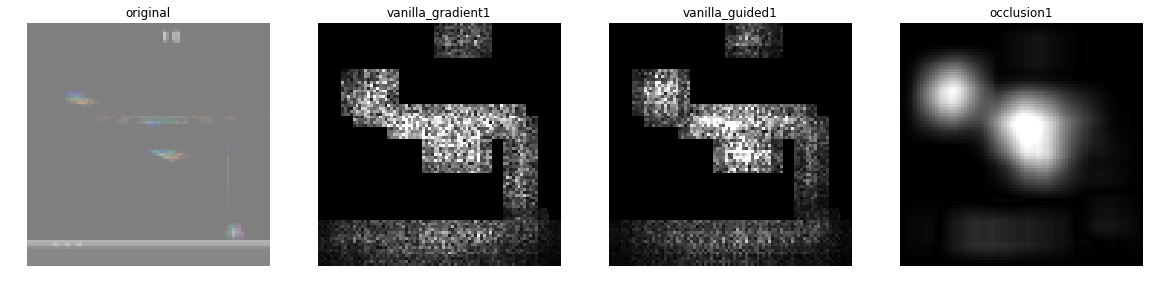

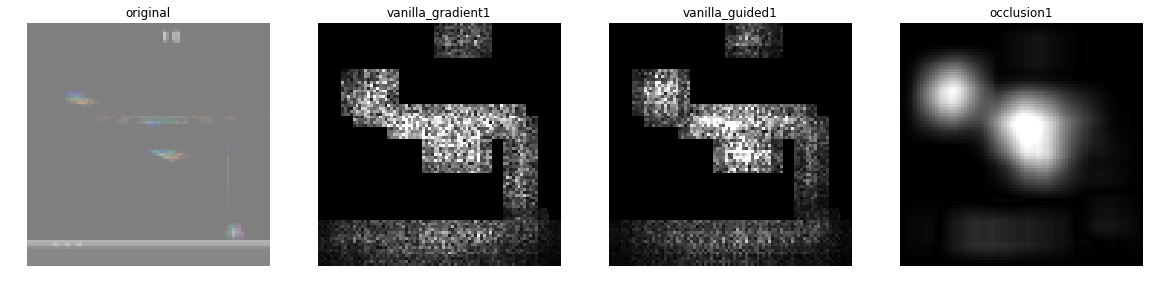

In [8]:
sess = tf.get_default_session()
ROWS = 1
COLS = 4
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
NUM_STEPS = 100

tf.global_variables_initializer().run(session=sess)
gradient_saliency = saliency.GradientSaliency(graph, sess, y_selected, images)
guided_backprop = saliency.GuidedBackprop(graph, sess, y_selected, images)
occlusion = saliency.Occlusion(graph, sess, y_selected, images)

for i in range(NUM_STEPS):
    obs, returns, masks, actions, values, neglogpacs, states, epinfos = runner.run() #pylint: disable=E0632

    prediction_class = sess.run(prediction, feed_dict = {images: [obs[0]]})[0]
    print("Time: {} \t Action: {}".format(i, prediction_class))
    
    vanilla_mask_3d = gradient_saliency.GetMask(obs[0], feed_dict = {neuron_selector: prediction_class})
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)

    vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(obs[0], feed_dict = {neuron_selector: prediction_class})
    vanilla_mask_guided_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
    
    occlusion_mask = occlusion.GetMask(obs[0].astype(np.float32), feed_dict = {neuron_selector: prediction_class})
    occlusion_mask_grayscale = saliency.VisualizeImageGrayscale(occlusion_mask)

    ShowImage(obs[0].astype(np.float32)/255., title='original', ax=P.subplot(ROWS, COLS, 1))
    ShowGrayscaleImage(vanilla_mask_grayscale, title='vanilla_gradient', pc=prediction_class, ax=P.subplot(ROWS, COLS, 2))
    ShowGrayscaleImage(vanilla_mask_guided_grayscale, title='vanilla_guided', pc=prediction_class, ax=P.subplot(ROWS, COLS, 3))
    ShowGrayscaleImage(occlusion_mask_grayscale, title="occlusion", pc=prediction_class, ax=P.subplot(ROWS, COLS, 4))
    
    display.clear_output(wait=True)
    display.display(P.gcf())